In [49]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, random_split
from torchvision import transforms
from PIL import Image
from time import time
import matplotlib.pyplot as plt
import json
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

In [3]:
class Config:
    def __init__(self):
        self.NUM_EPOCHS = 10
        self.NUM_CLASSES = 14
        self.BATCH_SIZE = 64
        self.VALIDATION_SPLIT = 0.5
        self.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.TRAIN_PATH = 'dataset/train/'
        self.TEST_PATH = 'dataset/test/'

config = Config()

In [4]:
print('Обучение будет проходить на {}'.format(config.DEVICE))

Обучение будет проходить на cuda


In [5]:
with open('utils/classes.json', 'r') as file:
    classes_color = json.load(file)

with open ('utils/classes_name.json', 'r') as file:
    classes_name = json.load(file)

print(classes_color)

{'cables': 0, 'case': 1, 'cpu': 2, 'gpu': 3, 'hdd': 4, 'headset': 5, 'keyboard': 6, 'microphone': 7, 'monitor': 8, 'motherboard': 9, 'mouse': 10, 'ram': 11, 'speakers': 12, 'webcam': 13}


In [6]:
print(classes_name)

{'0': 'cables', '1': 'case', '2': 'cpu', '3': 'gpu', '4': 'hdd', '5': 'headset', '6': 'keyboard', '7': 'microphone', '8': 'monitor', '9': 'motherboard', '10': 'mouse', '11': 'ram', '12': 'speakers', '13': 'webcam'}


In [40]:
class PCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data = os.listdir(self.root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index])
        img = Image.open(img_path)
        label = classes_color[self.data[index].split('_')[0]]

        if self.transform:
            img = self.transform(img)

        return img, label

In [41]:
train_dataset = PCDataset(config.TRAIN_PATH, transform = transforms.Compose([
                                            transforms.Resize((128, 128)),
                                            transforms.ToTensor(),
                                            transforms.RandomHorizontalFlip(p=0.5),
                                            transforms.RandomRotation(degrees=(-90, 90)),
                                            transforms.RandomVerticalFlip(p=0.5),
                                            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                            transforms.Normalize(mean=[0.5586, 0.5573, 0.5607],
                                                                std=[0.3643, 0.3583, 0.3583])
]))

test_dataset = PCDataset(config.TEST_PATH, transform=transforms.Compose([
                                            transforms.Resize((128, 128)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.5586, 0.5573, 0.5607],
                                                        std=[0.3643, 0.3583, 0.3583])
]))

In [30]:
def visualization_of_the_dataset(dataset, indices):
    plt.figure(figsize=(12, 9))
    num_images = len(indices)
    cols = min(num_images, 5)
    rows = num_images // cols + (num_images % cols > 0)

    for pos, index in enumerate(indices):
        plt.subplot(rows, cols, pos+1)
        img, label = dataset[index]
        plt.title(classes_name[str(label)])
        plt.imshow(img.permute(1, 2, 0))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

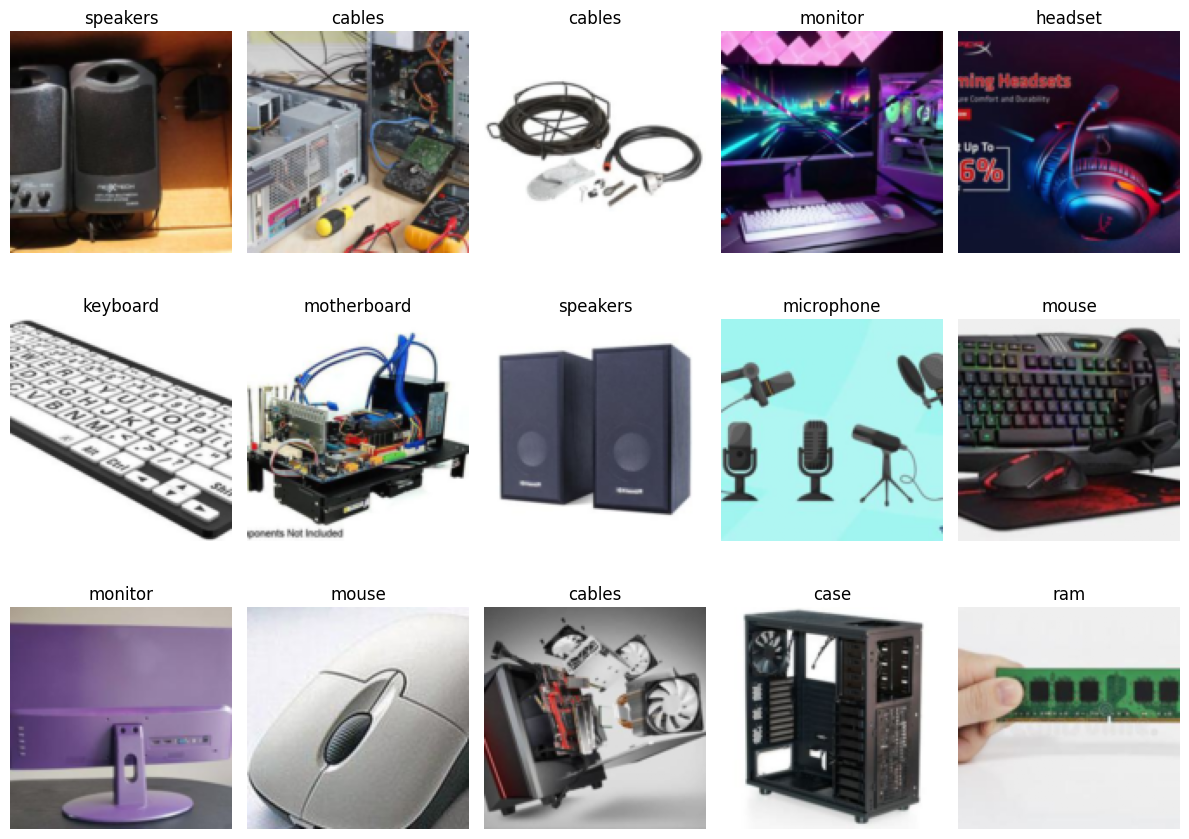

In [19]:
indices = np.random.choice(np.arange(test_dataset.__len__()), 15)
visualization_of_the_dataset(test_dataset, indices)

In [14]:
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)

In [15]:
imgs.view(3, -1).mean(dim=1)

In [16]:
imgs.view(3, -1).std(dim=1)

In [42]:
length_test_data = len(test_dataset)
indices = np.arange(length_test_data)

split_idx = int(np.floor(config.VALIDATION_SPLIT * length_test_data))
valid_indices, test_indices = indices[:split_idx], indices[split_idx:]

valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, sampler=valid_sampler)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, sampler=test_sampler)

In [32]:
class PCNet(nn.Module):
    def __init__(self, n_chans=32):
        super(PCNet, self).__init__()
        self.n_chans = n_chans
        self.conv1 = nn.Conv2d(3, n_chans, kernel_size=3, padding=1, stride=1)
        self.conv1_batch_norm = nn.BatchNorm2d(num_features=n_chans)
        self.conv2 = nn.Conv2d(n_chans, n_chans // 2, kernel_size=3, padding=1, stride=1)
        self.conv2_batch_norm = nn.BatchNorm2d(num_features=n_chans // 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_chans * 2 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, config.NUM_CLASSES)

    def forward(self, x):
        out = F.max_pool2d(F.relu(self.conv1_batch_norm(self.conv1(x))), 2)
        out = F.max_pool2d(F.relu(self.conv2_batch_norm(self.conv2(out))), 2)
        out = self.flatten(out)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [33]:
model = PCNet().to(config.DEVICE)
criterion = nn.CrossEntropyLoss().to(config.DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
sheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [34]:
def training_loop(num_epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    loss_history = []
    train_history = []
    valid_history = []

    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        start_time = time()

        for i_step, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(config.DEVICE), labels.to(config.DEVICE)
            prediction = model(imgs)
            loss = criterion(prediction, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_accum += loss.item()
            total_samples += labels.shape[0]

            _, out = torch.max(prediction, dim=1)
            correct_samples += torch.sum(out == labels).item()

        avg_loss = loss_accum / (i_step + 1)
        train_accuracy = correct_samples / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(avg_loss)
        train_history.append(train_accuracy)
        valid_history.append(val_accuracy)
        print('[{} | {}] Loss: {:.4f} | Train accuracy: {:.4f} | Validation Accuracy: {:.4f} | Time {:.2f}s'.format(epoch + 1, num_epochs, avg_loss, train_accuracy, val_accuracy, time() - start_time))

        if scheduler:
            scheduler.step()

    return loss_history, train_history, valid_history

def compute_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(config.DEVICE), labels.to(config.DEVICE)
            out = model(imgs)
            _, prediction = torch.max(out, dim=1)
            correct += torch.sum(prediction == labels).item()
            total += labels.shape[0]

    return correct / total


In [35]:
loss_history, train_history, val_history = training_loop(config.NUM_EPOCHS, model, train_loader, valid_loader, criterion, optimizer, sheduler)

[1 | 10] Loss: 2.7043 | Train accuracy: 0.1093 | Validation Accuracy: 0.0906 | Time 49.23s
[2 | 10] Loss: 2.5494 | Train accuracy: 0.1277 | Validation Accuracy: 0.1934 | Time 48.31s
[3 | 10] Loss: 2.5366 | Train accuracy: 0.1384 | Validation Accuracy: 0.0514 | Time 47.92s
[4 | 10] Loss: 2.4819 | Train accuracy: 0.1529 | Validation Accuracy: 0.0695 | Time 46.92s
[5 | 10] Loss: 2.4618 | Train accuracy: 0.1590 | Validation Accuracy: 0.0725 | Time 52.39s
[6 | 10] Loss: 2.4542 | Train accuracy: 0.1586 | Validation Accuracy: 0.0665 | Time 50.09s
[7 | 10] Loss: 2.4439 | Train accuracy: 0.1632 | Validation Accuracy: 0.0755 | Time 44.01s
[8 | 10] Loss: 2.4473 | Train accuracy: 0.1533 | Validation Accuracy: 0.0755 | Time 43.43s
[9 | 10] Loss: 2.4437 | Train accuracy: 0.1678 | Validation Accuracy: 0.0785 | Time 41.43s
[10 | 10] Loss: 2.4349 | Train accuracy: 0.1606 | Validation Accuracy: 0.0785 | Time 47.41s


# Efficientnet

In [43]:
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b3')

Loaded pretrained weights for efficientnet-b3


In [44]:
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b3')
num_ft = efficientnet_model._fc.in_features
for param in efficientnet_model.parameters():
    param.requires_grad = False

efficientnet_model._fc = nn.Linear(num_ft, config.NUM_CLASSES)
efficientnet_model.to(config.DEVICE)
optimizer = optim.Adam(efficientnet_model._fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(config.DEVICE)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Loaded pretrained weights for efficientnet-b3


In [45]:
loss_history, train_history, val_history = training_loop(config.NUM_EPOCHS, efficientnet_model, train_loader, valid_loader, criterion, optimizer, scheduler)

[1 | 10] Loss: 2.4281 | Train accuracy: 0.2450 | Validation Accuracy: 0.4199 | Time 56.47s
[2 | 10] Loss: 2.0361 | Train accuracy: 0.4174 | Validation Accuracy: 0.4804 | Time 52.18s
[3 | 10] Loss: 1.8411 | Train accuracy: 0.4656 | Validation Accuracy: 0.4653 | Time 60.50s
[4 | 10] Loss: 1.7591 | Train accuracy: 0.4889 | Validation Accuracy: 0.4743 | Time 49.90s
[5 | 10] Loss: 1.7520 | Train accuracy: 0.4843 | Validation Accuracy: 0.4683 | Time 47.27s
[6 | 10] Loss: 1.7493 | Train accuracy: 0.4901 | Validation Accuracy: 0.4502 | Time 35.18s
[7 | 10] Loss: 1.7105 | Train accuracy: 0.5019 | Validation Accuracy: 0.4562 | Time 42.25s
[8 | 10] Loss: 1.7474 | Train accuracy: 0.4989 | Validation Accuracy: 0.4562 | Time 63.07s
[9 | 10] Loss: 1.7230 | Train accuracy: 0.5015 | Validation Accuracy: 0.4471 | Time 68.95s
[10 | 10] Loss: 1.7106 | Train accuracy: 0.5061 | Validation Accuracy: 0.4441 | Time 62.60s


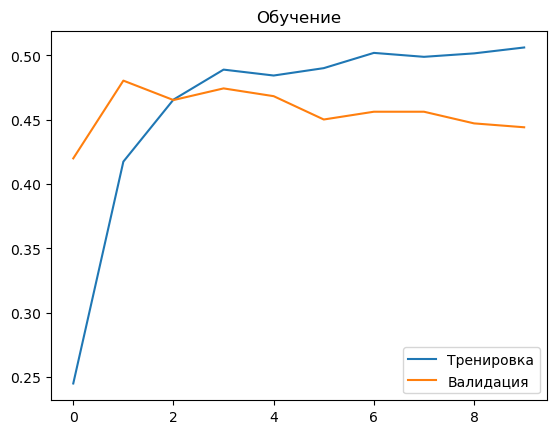

In [46]:
plt.plot(train_history, label='Тренировка');
plt.plot(val_history, label='Валидация');
plt.legend()
plt.title('Обучение');

In [47]:
def visualize_model_test(model, loader, num_imgs=6):
    fig = plt.figure()
    reverse_normalize = transforms.Compose([
        transforms.Normalize(mean=[-0.5586/0.3643, -0.5573/0.3583, -0.5607/0.3583], std=[1/0.3643, 1/0.3583, 1/0.3583]),
    ])

    with torch.no_grad():
        images_so_far = 0
        for (inputs, labels) in loader:
            inputs, labels = inputs.to(config.DEVICE), labels.to(config.DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_imgs//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes_name[str(preds[j].item())]}')
                original_image = reverse_normalize(inputs[j].cpu().detach())
                plt.imshow(original_image.permute(1, 2, 0))

                if images_so_far == num_imgs:
                    plt.tight_layout()
                    plt.show()
                    return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


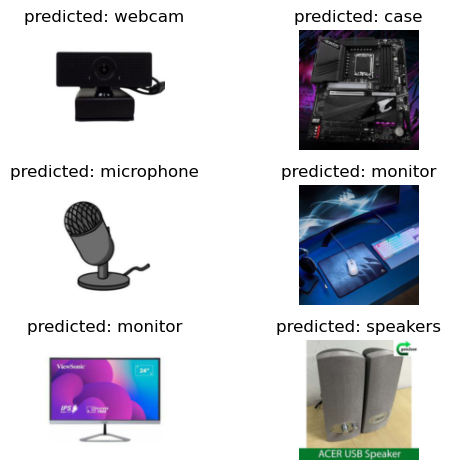

In [50]:
visualize_model_test(efficientnet_model, test_loader)